# Data Scientist Challenge Latam Airlines

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import math
import numpy as np
import re

Let's set a random seed to ensure reproducibility.

In [2]:
SEED = 2023

## Data loading

Below we create a dictionary with dtypes because pandas gives a warning with the columns Vlo-I and Vlo-O, some values are not just numbers, some numbers include letters.

In [3]:
dtypes = {
    'Fecha-I' : 'str',
    'Vlo-I' : 'str',
    'Ori-I' : 'str',
    'Des-I' : 'str',
    'Emp-I' : 'str',
    'Fecha-O' : 'str',
    'Vlo-O' : 'str',
    'Ori-O' : 'str',
    'Des-O' : 'str',
    'Emp-O' : 'str',
    'DIA' : 'int32',
    'MES' : 'int32',
    'AÑO' : 'int32',
    'DIANOM' : 'str',
    'TIPOVUELO' : 'str',
    'OPERA' : 'str',
    'SIGLAORI' : 'str',
    'SIGLADES' : 'str'
}

In [4]:
data = pd.read_csv("dataset_SCL.csv", dtype = dtypes)

#Change the format of the 'Fecha-I' column to datetime
data["Fecha-I"] = pd.to_datetime(data["Fecha-I"], format="%Y-%m-%d %H:%M:%S")
data["Fecha-O"] = pd.to_datetime(data["Fecha-O"], format="%Y-%m-%d %H:%M:%S")

With the data loaded, we can show a few of them, to see what we are working with

In [5]:
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


We can show a describe of the pandas DataFrame to see the statistics of the data, but almost all columns are strings, so is not useful.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  object        
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int32         
 11  MES        68206 non-null  int32         
 12  AÑO        68206 non-null  int32         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non-null  object       

We can see that there are 1 column with only one missing value. We can drop it or fill it. But we can see that the column 'Vlo-I' is the same of 'Vlo-O', so we can fill it with that value. But to show this, we have to transform both columns

In [7]:
def transformation(value):
    try:
        return str(int(float(value)))
    except:
        return value

In [8]:
data["Vlo-I"] = data["Vlo-I"].apply(transformation)
data["Vlo-O"] = data["Vlo-O"].apply(transformation)

Now we can show how many rows have 'Vlo-I' value containing a letter

In [9]:
data[data["Vlo-I"].str.contains("[a-zA-Z]", regex = True)]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
22232,2017-05-13 21:50:00,989P,SCEL,SUMU,AAL,2017-05-13 21:52:00,989,SCEL,SUMU,AAL,13,5,2017,Sabado,I,American Airlines,Santiago,Montevideo
27464,2017-06-16 20:30:00,940P,SCEL,KDFW,AAL,2017-06-16 20:50:00,940,SCEL,KDFW,AAL,16,6,2017,Viernes,I,American Airlines,Santiago,Dallas
39225,2017-08-07 19:00:00,591P,SCEL,LFPG,PUE,2017-08-07 20:35:00,591P,SCEL,LFPG,PUE,7,8,2017,Lunes,I,Plus Ultra Lineas Aereas,Santiago,Paris
39266,2017-08-24 23:00:00,846A,SCEL,KIAH,UAL,2017-08-24 23:00:00,2804,SCEL,KIAH,UAL,24,8,2017,Jueves,I,United Airlines,Santiago,Houston
58126,2017-11-05 17:00:00,1104A,SCEL,SCSE,SKU,2017-11-05 17:42:00,1104,SCEL,SCSE,SKU,5,11,2017,Domingo,N,Sky Airline,Santiago,La Serena


Given that the 'Vlo-I' have only 5 rows with letters, we can remove the letters and keep the numbers.

In [10]:
data["Vlo-I"] = data["Vlo-I"].apply(lambda x : re.sub("[a-zA-Z]", "", x)).astype("int32")

We can make same analysis of the other columns like ("Ori-I", "Ori-O"), ("Des-I", "Des-O") and ("Emp-I", "Emp-O"), but first we see how many pair values are the same:

In [11]:
columns = [("Ori-I", "Ori-O"), ("Des-I", "Des-O"), ("Emp-I", "Emp-O")]
for col1, col2 in columns:
    print(f"For {col1} and {col2} : {data[data.apply(lambda x : x[col1] != x[col2], axis = 1)].shape[0]} of {data.shape[0]} different values")

For Ori-I and Ori-O : 0 of 68206 different values
For Des-I and Des-O : 28 of 68206 different values
For Emp-I and Emp-O : 18669 of 68206 different values


This shows that are columns with redundant information, so in the future we can drop them.

## 1. How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

In [12]:
def plot_hist(data, column_x, column_y, title, x_label, y_label, figsize = (18, 8), text = False, angle = 0, mean = False):

    plt.figure(figsize = figsize)
    plt.bar(data[column_x], data[column_y], label = column_y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    if text:
        for i, value in zip(data[column_x], data[column_y]):
            plt.text(i, value, str(round(value)), ha='center', va='bottom')

    if mean:
        plt.axhline(data[column_y].mean(), color = "red", label = "Mean")
        plt.legend()
        
    plt.xticks(rotation=angle)
    plt.show()

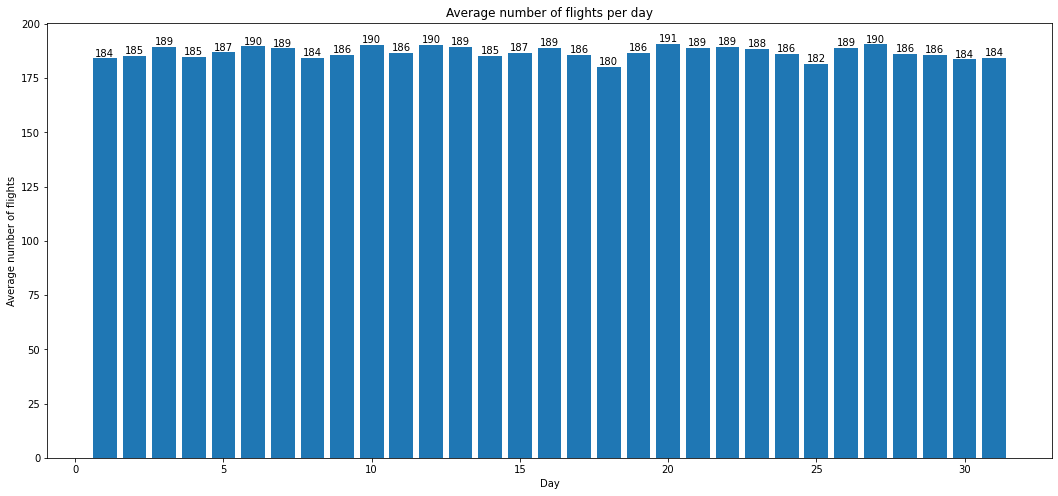

In [13]:
col = "DIA"

aux = data.groupby(["MES", "DIA"]).count()
aux = aux.reset_index()
aux = aux.groupby("DIA").mean().reset_index()[["DIA", "Fecha-I"]]

plot_hist(aux, "DIA", "Fecha-I", "Average number of flights per day", "Day", "Average number of flights", text = True)

We can conclude that on average, we have a good representation of every day of the month, so the data in the 'DIA' column is homogeneous.

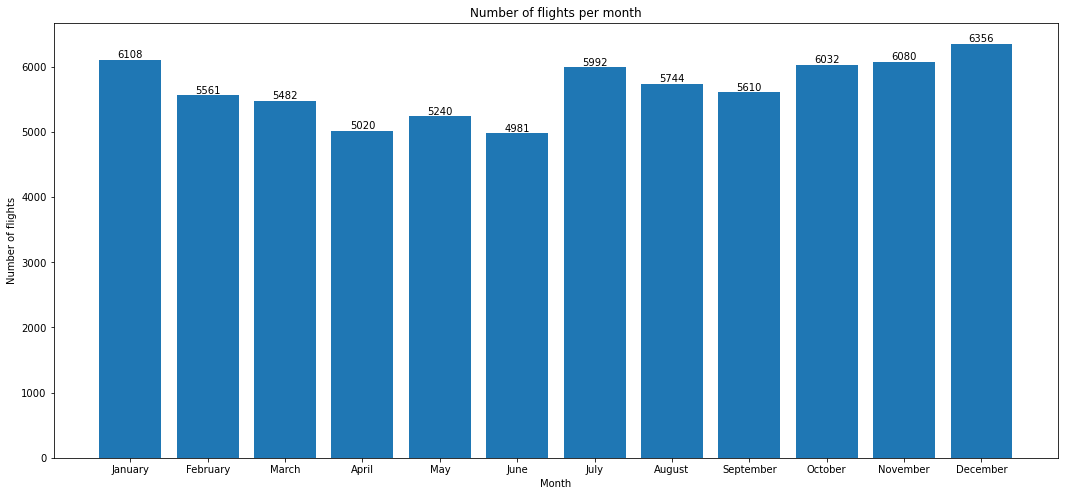

In [14]:
col = "MES"

aux = data.groupby("MES").count().reset_index()[["MES", "Fecha-I"]]
aux["MES"] = aux["MES"].apply(lambda x : ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"][x - 1])

plot_hist(aux, "MES", "Fecha-I", "Number of flights per month", "Month", "Number of flights", text = True)

Here we can see that there is a rise in the number of flights in the month of July. As a consequence, we can expect a rise in the delay time. This can be checked in the next questions. Another observation we can make is that the number of flights shows an increasing trend between September and January. This also may lead to an increase in the delay time of flights.



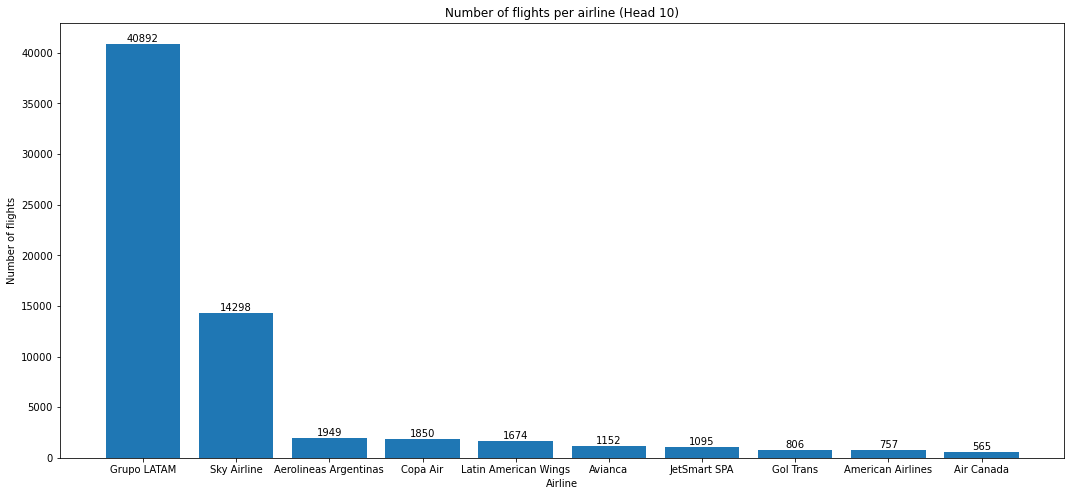

In [15]:
col = "OPERA"

aux = data.groupby("OPERA").count().reset_index()[["OPERA", "Fecha-I"]].sort_values("Fecha-I", ascending = False)
aux = aux.head(10)

plot_hist(aux, "OPERA", "Fecha-I", "Number of flights per airline (Head 10)", "Airline", "Number of flights", text = True)

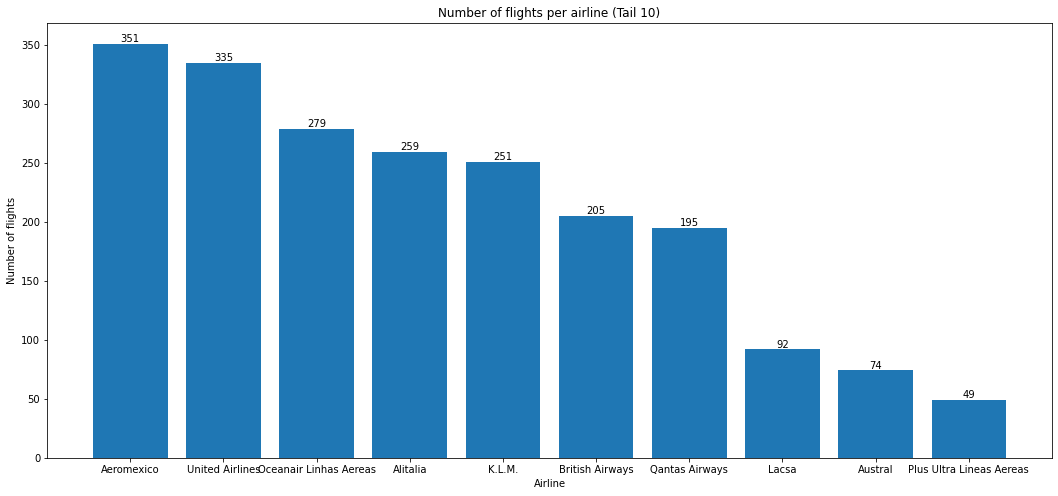

In [16]:
col = "OPERA"

aux = data.groupby("OPERA").count().reset_index()[["OPERA", "Fecha-I"]].sort_values("Fecha-I", ascending = False)
aux = aux.tail(10)

plot_hist(aux, "OPERA", "Fecha-I", "Number of flights per airline (Tail 10)", "Airline", "Number of flights", text = True)

By looking at two graphs, we can see that there is an evident concentration of flights in only two airlines. As a result, we have an imbalance in the data for this column. Out of a total of 68206 flights, Latam has 59.96% of the flights and Sky Airline has 20.96% of the flights, which means these two airlines account for 80.92% of the flights. The remaining 21 airlines account for 19.08% of the flights.

In [17]:
data["SIGLAORI"].unique().tolist()

['Santiago']

Please note that the only origin airport is Santiago. Therefore, this column is not useful for making predictions.

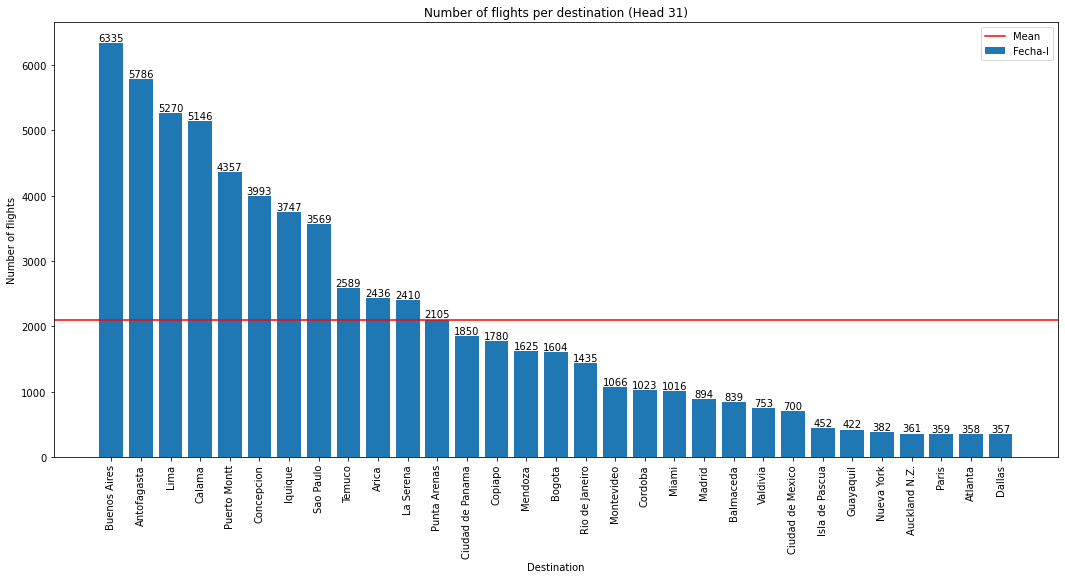

In [18]:
col = "SIGLADES"

aux = data.groupby("SIGLADES").count().reset_index()[["SIGLADES", "Fecha-I"]].sort_values("Fecha-I", ascending = False)
aux = aux.head(31)

plot_hist(aux, "SIGLADES", "Fecha-I", "Number of flights per destination (Head 31)", "Destination", "Number of flights", text = True, angle = 90, mean = True)

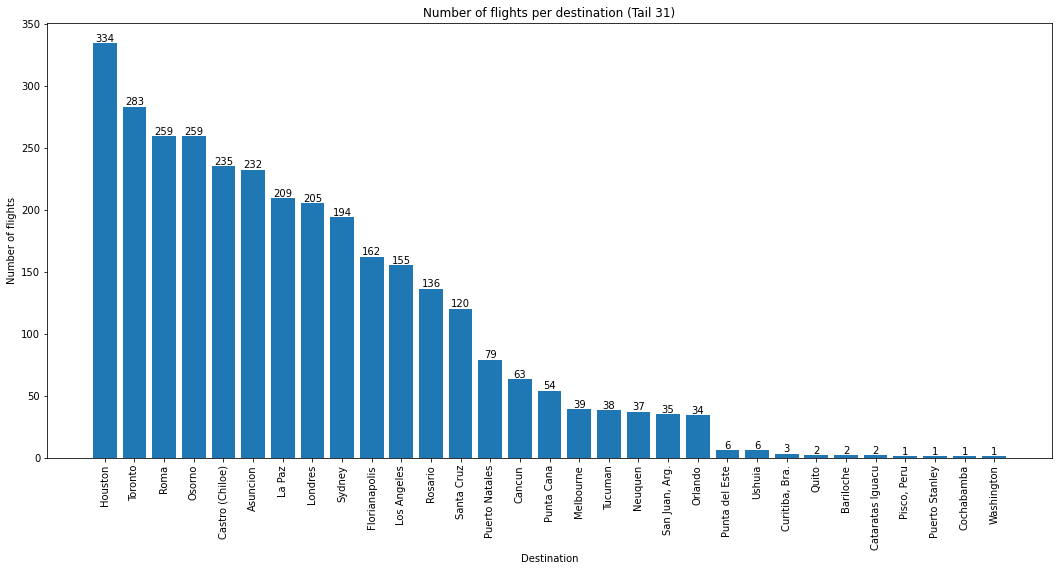

In [19]:
col = "SIGLADES"

aux = data.groupby("SIGLADES").count().reset_index()[["SIGLADES", "Fecha-I"]].sort_values("Fecha-I", ascending = False)
aux = aux.tail(31)

plot_hist(aux, "SIGLADES", "Fecha-I", "Number of flights per destination (Tail 31)", "Destination", "Number of flights", text = True, angle = 90)

From these charts, we can observe that more than half of the data (62 destinations) are below the mean. This indicates that we have overrepresented and underrepresented data, which means that predicting the delay time will be more difficult for certain destinations.

In [20]:
col = "TIPOVUELO"

aux = data.groupby("TIPOVUELO").count().reset_index()[["TIPOVUELO", "Fecha-I"]].sort_values("Fecha-I", ascending = False)
aux

,TIPOVUELO,Fecha-I
1,N,36966
0,I,31240


Here, we notice that the type of flight is well balanced. Therefore, this column can potentially provide relevant information for predicting the delay.

## 2. Generate the following additional columns.

Please export them to a CSV file named synthetic_features.csv:
  - high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
  - min_diff : difference in minutes between Date-O and Date-I .
  - delay_15 : 1 if min_diff > 15, 0 if not.
  - period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based onDate-I.

In [21]:
def high_season(date):
    dec_15 = pd.Timestamp(date.year, 12, 15)
    mar_3 = pd.Timestamp(date.year, 3, 3)

    jul_15 = pd.Timestamp(date.year, 7, 15)
    jul_31 = pd.Timestamp(date.year, 7, 31)

    sep_11 = pd.Timestamp(date.year, 9, 11)
    sep_30 = pd.Timestamp(date.year, 9, 30)

    return int((dec_15 <= date <= mar_3) or (jul_15 <= date <= jul_31) or (sep_11 <= date <= sep_30))

def period_day(date):
    morning_start = pd.Timestamp(date.year, date.month, date.day, 5, 0)
    morning_end = pd.Timestamp(date.year, date.month, date.day, 11, 59)

    afternoon_start = pd.Timestamp(date.year, date.month, date.day, 12, 0)
    afternoon_end = pd.Timestamp(date.year, date.month, date.day, 18, 59)

    if morning_start <= date <= morning_end:
        return "morning"
    elif afternoon_start <= date <= afternoon_end:
        return "afternoon"
    else:
        return "night"

In [22]:
data["high_season"] = data["Fecha-I"].apply(high_season)
data["min_diff"] = data.apply(lambda x : (x["Fecha-O"] - x["Fecha-I"]).total_seconds() / 60, axis = 1)
data["delay_15"] = data["min_diff"].apply(lambda x : int(x > 15))
data["period_day"] = data["Fecha-I"].apply(period_day)

In [23]:
data.to_csv("synthetic_features.csv", index = False)

## 3. What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight? What variables would you expect to have the most influence in predicting delays?

In [24]:
data_aux = data.copy()
data_aux["fecha"] = data_aux.apply(lambda x : f"{x['AÑO']}-{x['MES']}-{x['DIA']}", axis = 1)
data_aux["fecha"] = pd.to_datetime(data_aux["fecha"], format="%Y-%m-%d")
data_aux["dia_semana"] = data_aux["DIANOM"].apply(lambda x : ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo'].index(x))

In [25]:
data_aux["delay"] = (data_aux["Fecha-O"] - data_aux["Fecha-I"]).dt.total_seconds()

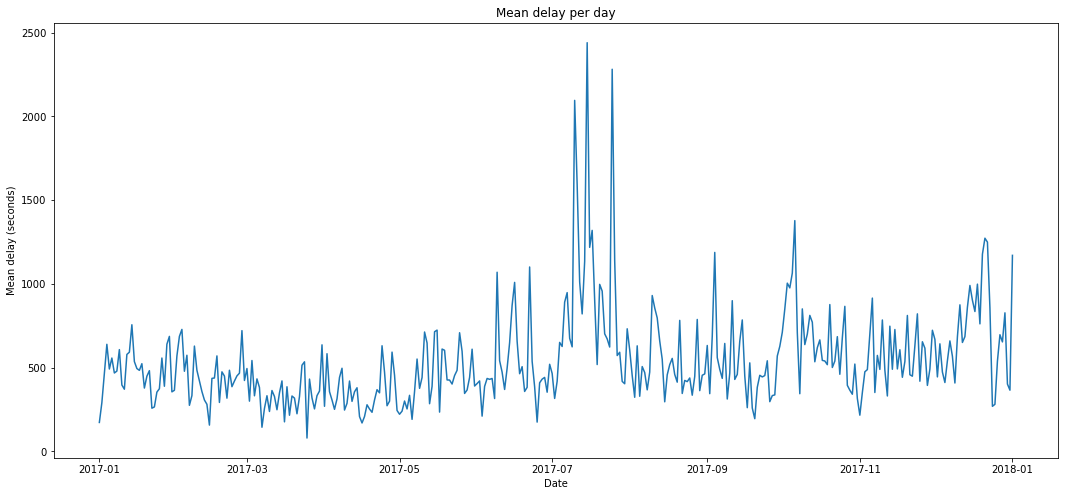

In [26]:
aux = data_aux.groupby("fecha").agg({"delay" : "mean"}).reset_index()
plt.figure(figsize = (18, 8))
plt.plot(aux["fecha"], aux["delay"])
plt.xlabel("Date")
plt.ylabel("Mean delay (seconds)")
plt.title("Mean delay per day")
plt.show()

We can see that there are no visible patterns in the data except for the obvious rise in July. However, this behavior can be explained by the increase in the number of flights during that month, as we have shown previously.

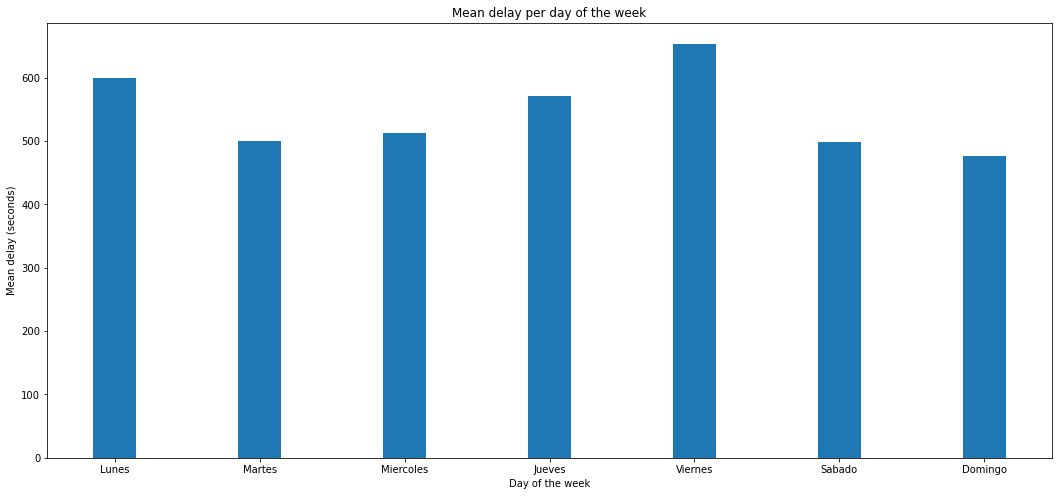

In [27]:
aux = data_aux.groupby("dia_semana").agg({"delay" : "mean"}).reset_index()
aux["dia_semana"] = aux["dia_semana"].apply(lambda x : ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo'][x])
plt.figure(figsize = (18, 8))
plt.bar(aux["dia_semana"], aux["delay"], width = 0.3)
plt.xlabel("Day of the week")
plt.ylabel("Mean delay (seconds)")
plt.title("Mean delay per day of the week")
plt.show()

From this graph, we can see that the mean delay is higher on Friday and Monday and lower on Saturday and Sunday. This behavior can be explained by the same idea mentioned previously, that an increase in the number of flights can lead to an increase in delays. This can be confirmed by examining the number of flights per day of the week.

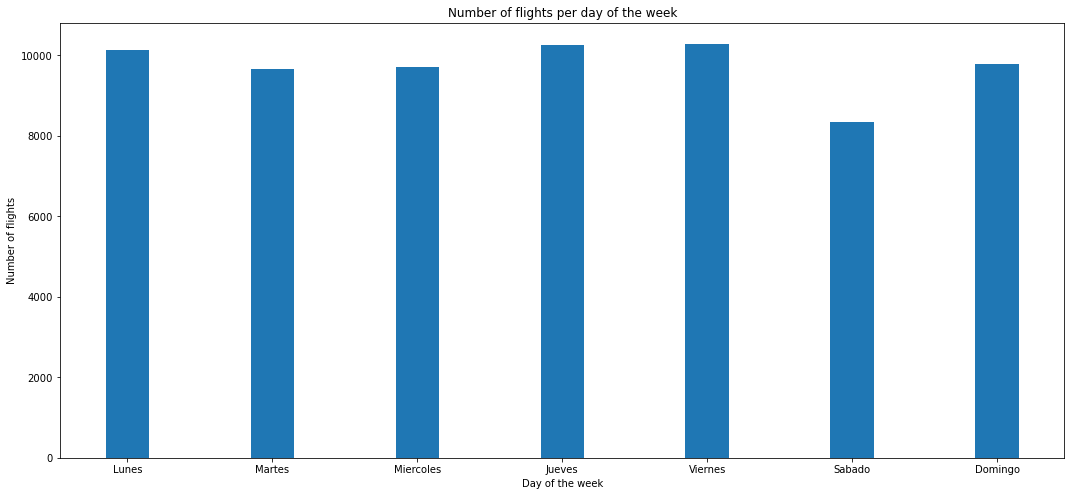

In [28]:
aux = data_aux.groupby("dia_semana").count().reset_index()[["dia_semana", "Fecha-I"]]
aux["dia_semana"] = aux["dia_semana"].apply(lambda x : ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo'][x])
plt.figure(figsize = (18, 8))
plt.bar(aux["dia_semana"], aux["Fecha-I"], width = 0.3)
plt.xlabel("Day of the week")
plt.ylabel("Number of flights")
plt.title("Number of flights per day of the week")
plt.show()

This graph shows us that on Monday, Thursday, and Friday, there are more flights than on the other days, while on Saturday, there are fewer flights. This can be explained by the fact that many people travel for the weekend, so they travel on Friday and return on Monday or Sunday. This leads us to think that the delay time actually increases when the demand for air travel increases.

Another possible relationship is between the delay and the type of flight, so we will analyze it.

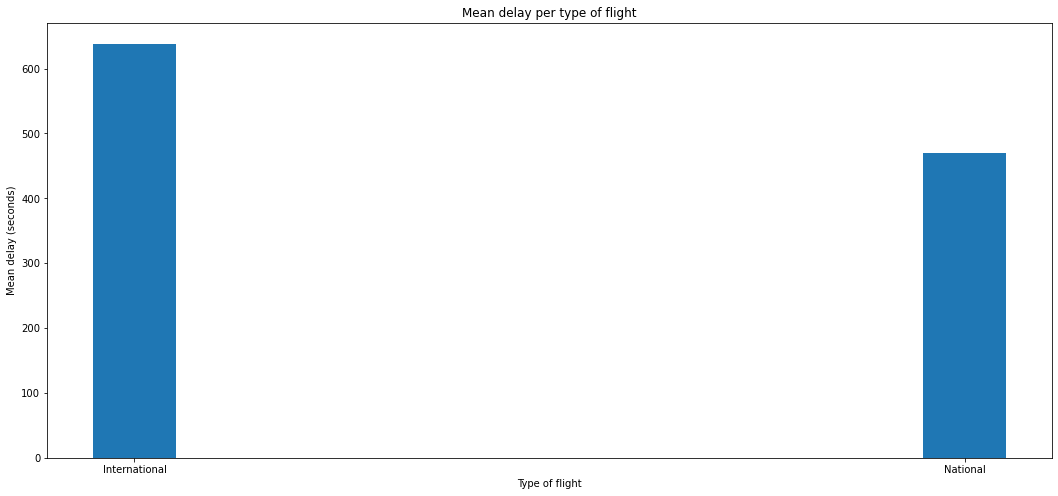

In [29]:
aux = data_aux.groupby("TIPOVUELO").agg({"delay" : "mean"}).reset_index()
aux["TIPOVUELO"] = aux["TIPOVUELO"].apply(lambda x : {'I' : 'International', 'N' : 'National'}[x])
plt.figure(figsize = (18, 8))
plt.bar(aux["TIPOVUELO"], aux["delay"], width = 0.1)
plt.xlabel("Type of flight")
plt.ylabel("Mean delay (seconds)")
plt.title("Mean delay per type of flight")
plt.show()

This shows that the delay may be related to the type of flight, because the mean delay is higher for international flights, wich can be logical because they can have more bureaucratic processes.

Now we will analyze if the destination airport has an impact on the delay

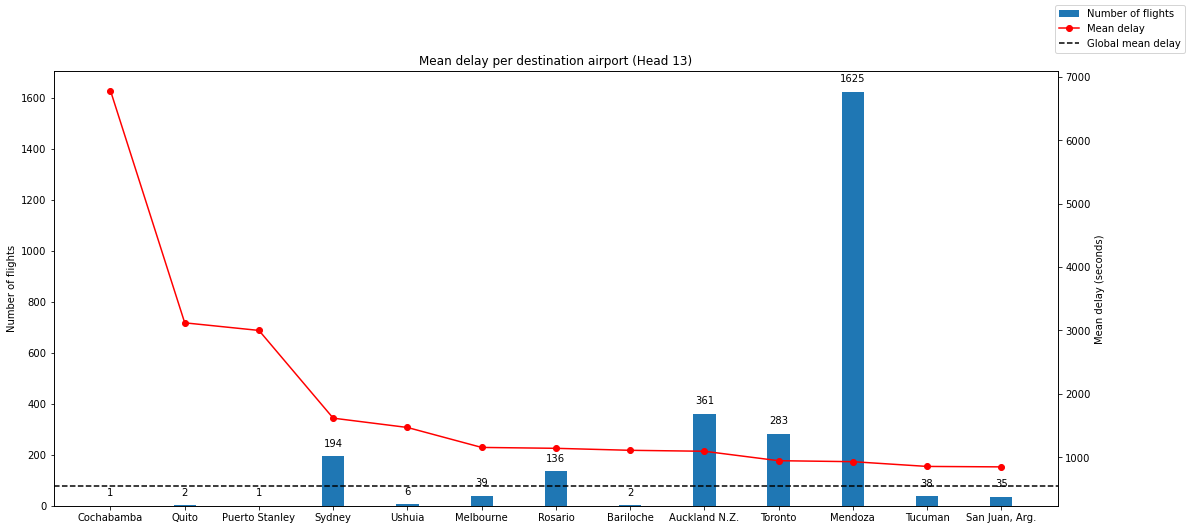

In [30]:
aux_delay = data_aux.groupby("SIGLADES").agg({"delay" : "mean", 'MES' : 'count'}).reset_index().sort_values("delay", ascending = False).head(13)

fig, ax1 = plt.subplots(figsize = (18, 8))
ax2 = ax1.twinx()

ax2.plot(aux_delay["SIGLADES"], aux_delay["delay"],color = "red", marker = "o", label = "Mean delay")
ax2.set_xlabel("Destination airport")
ax2.set_ylabel("Mean delay (seconds)")
ax2.set_title("Mean delay per destination airport (Head 13)")

ax1.bar(aux_delay["SIGLADES"], aux_delay["MES"], width = 0.3, label = "Number of flights")
ax1.set_ylabel("Number of flights")

for x, y in zip(aux_delay["SIGLADES"], aux_delay["MES"]):
    ax1.annotate(str(y), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

ax2.axhline(data_aux["delay"].mean(), color = "black", linestyle = "--", label = "Global mean delay")

fig.legend(loc = "upper right")
plt.show()

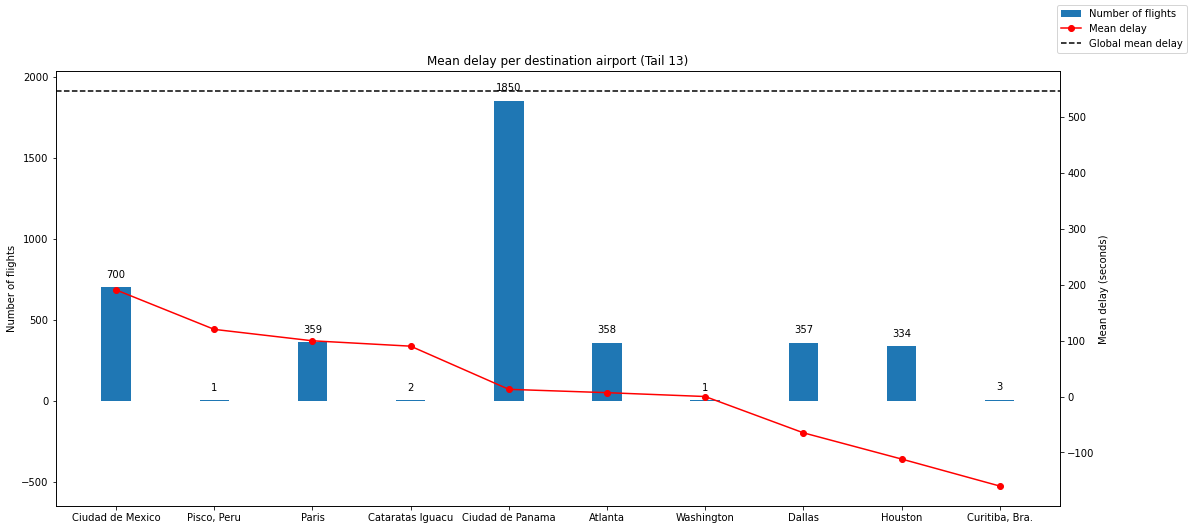

In [31]:
aux_delay = data_aux.groupby("SIGLADES").agg({"delay" : "mean", 'MES' : 'count'}).reset_index().sort_values("delay", ascending = False).tail(10)

fig, ax1 = plt.subplots(figsize = (18, 8))

ax1.bar(aux_delay["SIGLADES"], aux_delay["MES"], width = 0.3, label = "Number of flights")
ax1.set_ylabel("Number of flights")

gap = 650
ax1.set_ylim([-gap, aux_delay["MES"].max()*1.1])

for x, y in zip(aux_delay["SIGLADES"], aux_delay["MES"]):
    ax1.annotate(str(y), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

ax2 = ax1.twinx()

ax2.plot(aux_delay["SIGLADES"], aux_delay["delay"], color = "red", marker = "o", label = "Mean delay")
ax2.set_xlabel("Destination airport")
ax2.set_ylabel("Mean delay (seconds)")
ax2.set_title("Mean delay per destination airport (Tail 13)")

ax2.axhline(data_aux["delay"].mean(), color = "black", linestyle = "--", label = "Global mean delay")

fig.legend(loc = "upper right")
plt.show()

With these two graphs, we can see that there are some airports that consistently have significantly fewer delays than the global mean delay. However, we cannot be certain that the destination is always a significant factor in the delay of the flight because some destinations do not have enough data.

Additionally, we see that the airline distribution is unbalanced, with only two airlines dominating the dataset as we mentioned previously. However, some airlines have significantly higher delays than the global mean delay, indicating that the airline may be a significant factor in the delay in some cases.

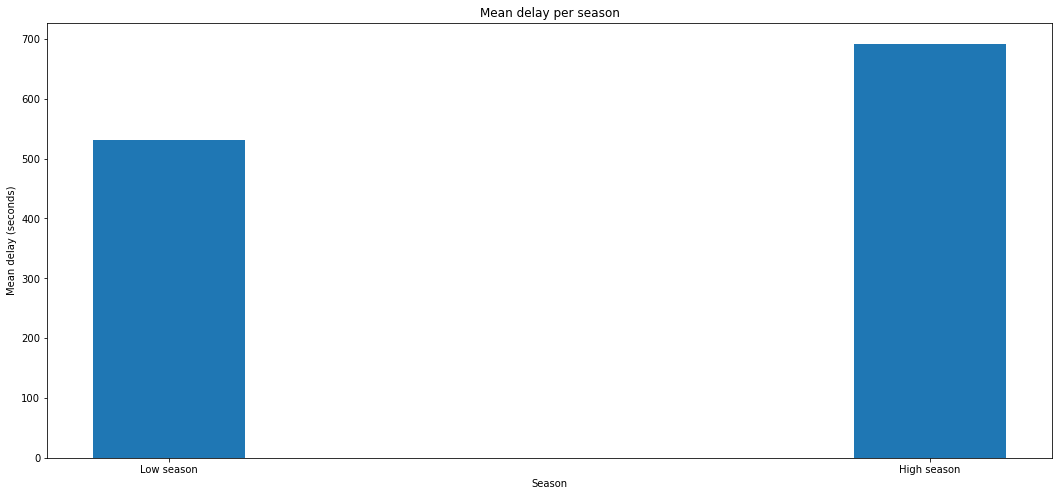

In [32]:
aux = data_aux.groupby("high_season").agg({"delay" : "mean"}).reset_index()
aux["high_season"] = aux["high_season"].apply(lambda x : {0 : "Low season", 1 : "High season"}[x])
plt.figure(figsize = (18, 8))
plt.bar(aux["high_season"], aux["delay"], width = 0.2)
plt.xlabel("Season")
plt.ylabel("Mean delay (seconds)")
plt.title("Mean delay per season")
plt.show()

We can observe that, as expected, flights tend to be more delayed during high seasons. Therefore, this variable can have a significant impact on the prediction.

## 4. Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay.

Feel free to generate additional variables and/or supplement with external variables.

All the previous analyses, although based on common sense, do not provide a definitive understanding of the relationship between the variables and the delay time. Therefore, we will now perform an analysis using techniques that allow us to obtain a more objective measurement of this relationship.

The techniques that we will use include PCA and Mutual Information.

To use PCA we need to have only numeric columns, so we will perform one-hot encoding on the categorical columns.

In [33]:
def one_hot_encoding(data, columns):
    data_aux = data.copy()
    for column in columns:
        data_aux[column] = data_aux[column].astype(str)
    data_aux = pd.get_dummies(data_aux, columns = columns)
    return data_aux

Since not all the presented columns are truly relevant or at least not as they are presented, we propose the following columns:

- vlo: 1 if Vlo-I is not equal to Vlo-O, 0 otherwise.
- Ori: 1 if Ori-I is not equal to Ori-O, 0 otherwise.
- Des: 1 if Des-I is not equal to Des-O, 0 otherwise.
- Emp-I: 1 if Emp-I is not equal to Emp-O, 0 otherwise.

In [34]:
data_aux = data.copy()

In [35]:
data_aux["vlo"] = (data_aux["Vlo-I"] != data_aux["Vlo-O"]).astype(int)
data_aux["Ori"] = (data_aux["Ori-I"] != data_aux["Ori-O"]).astype(int)
data_aux["Des"] = (data_aux["Des-I"] != data_aux["Des-O"]).astype(int)
data_aux["Emp-I"] = (data_aux["Emp-I"] != data_aux["Emp-O"]).astype(int)

From now on, we can remove the columns that we used to create these new ones.

In [36]:
data_aux = data_aux.drop(["Vlo-I", "Vlo-O", "Ori-I", "Ori-O", "Des-I", "Des-O", "Emp-I", "Emp-O"], axis = 1)

Since the columns "Fecha-I" and "Fecha-O" are included in the "delay_15" column, we can also remove them.

In [37]:
data_aux = data_aux.drop(["Fecha-I", "Fecha-O"], axis = 1)

Now we will implement a cyclic encoding to encode the day and month separately to provide the model with the cyclic nature of days and months that could affect the number of flights at a given time and consequently, alter the waiting time in trips.

In [38]:
def cyclic_encoding_static(data, column, max_value):
    data_aux = data.copy()
    data_aux[column + "_sin"] = np.sin(2 * np.pi * (data_aux[column] - 1)/max_value)
    data_aux[column + "_cos"] = np.cos(2 * np.pi * (data_aux[column] - 1)/max_value)
    return data_aux

Since the number of days in a month is variable, we need to use a different cyclic encoding for the days. For example, February can have 28 days while March can have 31. Therefore, we cannot use a static cyclic encoding.

In [39]:
def cyclic_encoding_day(data, column_day, column_month, column_year):
    data_aux = data.copy()
    data_aux["daysinmonth"] = data_aux.apply(lambda x : pd.Timestamp(year = x[column_year], month = x[column_month], day = 1).days_in_month, axis = 1)
    data_aux[column_day + "_sin"] = np.sin(2 * np.pi * (data_aux[column_day] - 1)/data_aux["daysinmonth"])
    data_aux[column_day + "_cos"] = np.cos(2 * np.pi * (data_aux[column_day] - 1)/data_aux["daysinmonth"])
    return data_aux.drop(["daysinmonth"], axis = 1)

In [40]:
data_aux = cyclic_encoding_day(data_aux, "DIA", "MES", "AÑO")
data_aux = cyclic_encoding_static(data_aux, "MES", 12)
data_aux = data_aux.drop(["DIA", "MES", "AÑO"], axis = 1)

In [41]:
columns = data_aux.select_dtypes(include = "object").columns
data_aux = one_hot_encoding(data_aux, columns)

In [42]:
data_aux.head()

,high_season,min_diff,delay_15,vlo,Ori,Des,DIA_sin,DIA_cos,MES_sin,MES_cos,...,SIGLADES_Sydney,SIGLADES_Temuco,SIGLADES_Toronto,SIGLADES_Tucuman,SIGLADES_Ushuia,SIGLADES_Valdivia,SIGLADES_Washington,period_day_afternoon,period_day_morning,period_day_night
0,0,3.0,0,1,0,0,0.000000,1.000000,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,0,9.0,0,1,0,0,0.201299,0.979530,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,0,9.0,0,1,0,0,0.394356,0.918958,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
3,0,3.0,0,1,0,0,0.571268,0.820763,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,0,-2.0,0,1,0,0,0.724793,0.688967,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1


Now that we are ready to apply PCA, we need to split the data into training and testing sets before doing so.

In [43]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=SEED)

for train_index, test_index in split.split(data_aux.drop(["delay_15"], axis = 1), data_aux[["delay_15"]]):
    X_train = data_aux.iloc[train_index].drop("delay_15", axis=1)
    X_test = data_aux.iloc[test_index].drop("delay_15", axis=1)
    y_train = data_aux.iloc[train_index]["delay_15"]
    y_test = data_aux.iloc[test_index]["delay_15"]

We need to perform a stratified split because, as we saw before, the data is highly imbalanced.

In [44]:
pca = PCA(n_components = int(X_train.shape[1] * 0.8), random_state = SEED)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

After performing the PCA transformation, we can then proceed with the Mutual Information feature selection technique.

In [45]:
mutual_inf = mutual_info_classif(X_train_pca, y_train, random_state = SEED)

In [46]:
mean = mutual_inf.mean()
mean

0.030353255338627348

In [47]:
columns_mi = X_train.columns[np.where(mutual_inf > mean)[0]]
columns_mi

Index(['high_season', 'min_diff', 'DIA_cos', 'DIANOM_Domingo', 'DIANOM_Jueves',
       'DIANOM_Lunes', 'OPERA_Avianca', 'OPERA_Gol Trans', 'OPERA_Iberia',
       'OPERA_JetSmart SPA', 'OPERA_K.L.M.', 'OPERA_Lacsa', 'SIGLADES_Arica',
       'SIGLADES_Asuncion', 'SIGLADES_Atlanta', 'SIGLADES_Balmaceda',
       'SIGLADES_Buenos Aires', 'SIGLADES_Cancun', 'SIGLADES_Cataratas Iguacu',
       'SIGLADES_Ciudad de Panama', 'SIGLADES_Isla de Pascua',
       'SIGLADES_La Paz', 'SIGLADES_La Serena', 'SIGLADES_Melbourne',
       'SIGLADES_Orlando'],
      dtype='object')

In [48]:
X_train_mi = X_train[columns_mi]
X_test_mi = X_test[columns_mi]

In [49]:
X_test_mi.head()

,high_season,min_diff,DIA_cos,DIANOM_Domingo,DIANOM_Jueves,DIANOM_Lunes,OPERA_Avianca,OPERA_Gol Trans,OPERA_Iberia,OPERA_JetSmart SPA,...,SIGLADES_Balmaceda,SIGLADES_Buenos Aires,SIGLADES_Cancun,SIGLADES_Cataratas Iguacu,SIGLADES_Ciudad de Panama,SIGLADES_Isla de Pascua,SIGLADES_La Paz,SIGLADES_La Serena,SIGLADES_Melbourne,SIGLADES_Orlando
15286,0,12.0,0.528964,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19598,0,2.0,0.669131,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62827,0,-2.0,0.688967,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38347,1,15.0,-0.954139,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38298,1,5.0,0.918958,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's try using the most basic models.

### Logistic Regression

In [50]:
lr_pca = LogisticRegression(random_state = SEED)
lr_pca.fit(X_train_pca, y_train)

lr_mi = LogisticRegression(random_state = SEED)
lr_mi.fit(X_train_mi, y_train)

y_pred_pca = lr_pca.predict(X_test_pca)
y_pred_mi = lr_mi.predict(X_test_mi)

print("PCA")
print(classification_report(y_test, y_pred_pca))

print("Mutual information")
print(classification_report(y_test, y_pred_mi))

PCA
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11119
           1       1.00      1.00      1.00      2523

    accuracy                           1.00     13642
   macro avg       1.00      1.00      1.00     13642
weighted avg       1.00      1.00      1.00     13642

Mutual information
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11119
           1       1.00      1.00      1.00      2523

    accuracy                           1.00     13642
   macro avg       1.00      1.00      1.00     13642
weighted avg       1.00      1.00      1.00     13642

